# Topic Modeling with Amortized LDA

In this tutorial, we will explore how to run the amortized Latent Dirichlet Allocation (LDA) model implementation in scvi-tools. LDA is a topic modelling method first introduced in the natural language processing field. By treating each cell as a document and each gene expression count as a word, we can carry over the method to the single-cell biology field.

Below, we will train the model over a dataset, plot the topics over a UMAP of the reference set, and inspect the topics for characteristic gene sets.

As an example, we use the PBMC 10K dataset from 10x Genomics.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/usr/local/lib/python3.12/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch

/usr/local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:388: SyntaxWarning: invalid escape sequence '\m'
  """ Implements modularity. This quality function is well-defined only for positive edge weights.
/usr/local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:761: SyntaxWarning: invalid escape sequence '\m'
  """ Implements Reichardt and Bornholdt's Potts model with a configuration null model.
/usr/local/lib/python3.12/site-packages/leidenalg/Optimiser.py:7: SyntaxWarning: invalid escape sequence '\g'
  """ Class for doing community detection using the Leiden algorithm.
/usr/local/lib/python3.12/site-packages/leidenalg/Optimiser.py:305: SyntaxWarning: invalid escape sequence '\s'
  """ Optimise the given partitions simultaneously.


/usr/local/lib/python3.12/site-packages/pyro/ops/stats.py:514: SyntaxWarning: invalid escape sequence '\g'
  """


In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.6


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Load and process data

Load the 10x genomics PBMC dataset. Generally, it is good practice for LDA to remove ubiquitous genes, to prevent the model from modeling these genes as a separate topic. Here, we first filter out all mitochrondrial genes, then select the top 1000 variable genes with seurat_v3 method from the remaining genes.

In [5]:
adata_path = os.path.join(save_dir.name, "pbmc_10k_protein_v3.h5ad")
adata = sc.read(
    adata_path,
    backup_url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true",
)

adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

adata = adata[:, ~adata.var_names.str.startswith("MT-")]
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=1000, subset=True
)

  0%|          | 0.00/23.8M [00:00<?, ?B/s]

/usr/local/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


## Create and fit `AmortizedLDA` model

Here, we initialize and fit an `AmortizedLDA` model on the dataset. We pick 10 topics to model in this case.

In [6]:
n_topics = 10

scvi.model.AmortizedLDA.setup_anndata(adata, layer="counts")
model = scvi.model.AmortizedLDA(adata, n_topics=n_topics)

```{note}
By default we train with KL annealing which means the effective loss will generally not decrease steadily in the beginning. Our Pyro implementations present this train loss term as the `elbo_train` in the progress bar which is misleading. We plan on correcting this in the future.
```

In [7]:
model.train()

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


/usr/local/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


## Visualizing learned topics

By calling `model.get_latent_representation()`, the model will compute a Monte Carlo estimate of the topic proportions for each cell. Since we use a logistic-Normal distribution to approximate the Dirichlet distribution, the model cannot compute the analytic mean. The number of samples used to compute the latent representation can be configured with the optional argument `n_samples`.

In [8]:
topic_prop = model.get_latent_representation()
topic_prop.head()

topic_0   topic_1   topic_2   topic_3   topic_4  \
index                                                                  
AAACCCAAGATTGTGA-1  0.000442  0.000388  0.184993  0.002144  0.752604   
AAACCCACATCGGTTA-1  0.001727  0.000209  0.001586  0.001331  0.969433   
AAACCCAGTACCGCGT-1  0.002755  0.002519  0.427630  0.001193  0.493127   
AAACCCAGTATCGAAA-1  0.000939  0.002033  0.001625  0.001936  0.001200   
AAACCCAGTCGTCATA-1  0.000770  0.000189  0.000200  0.000244  0.000176   

                     topic_5   topic_6   topic_7   topic_8   topic_9  
index                                                                 
AAACCCAAGATTGTGA-1  0.055904  0.003084  0.000102  0.000109  0.000229  
AAACCCACATCGGTTA-1  0.025163  0.000204  0.000115  0.000183  0.000048  
AAACCCAGTACCGCGT-1  0.040972  0.027584  0.000575  0.002702  0.000943  
AAACCCAGTATCGAAA-1  0.001432  0.001604  0.001056  0.009517  0.978658  
AAACCCAGTCGTCATA-1  0.000162  0.000243  0.000100  0.000598  0.997318

In [9]:
# Save topic proportions in obsm and obs columns.
adata.obsm["X_LDA"] = topic_prop
for i in range(n_topics):
    adata.obs[f"LDA_topic_{i}"] = topic_prop[[f"topic_{i}"]]

### Plot UMAP

In [10]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)

# Save UMAP to custom .obsm field.
adata.obsm["raw_counts_umap"] = adata.obsm["X_umap"].copy()

/tmp/ipykernel_153/3535892313.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)


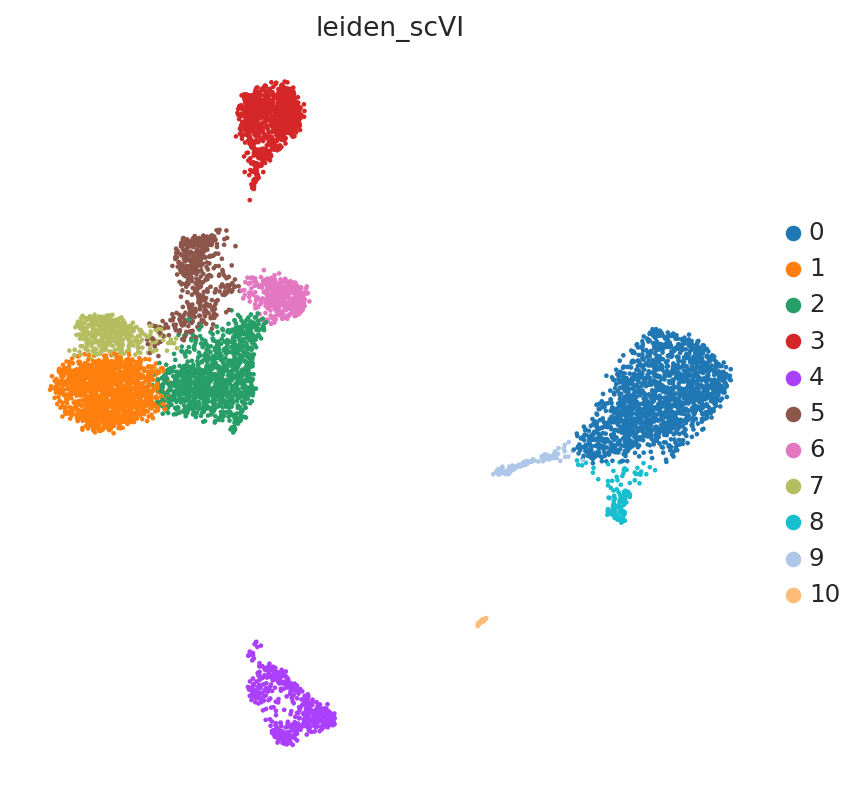

In [11]:
sc.pl.embedding(adata, "raw_counts_umap", color=["leiden_scVI"], frameon=False)

### Color UMAP by topic proportions

By coloring by UMAP by topic proportions, we find that the learned topics are generally dominant in cells close together in the UMAP space. In some cases, a topic is dominant in multiple clusters in the UMAP, which indicates similarilty between these clusters despite being far apart in the plot. This is not surprising considering that UMAP does not preserve local relationships beyond a certain threshold.

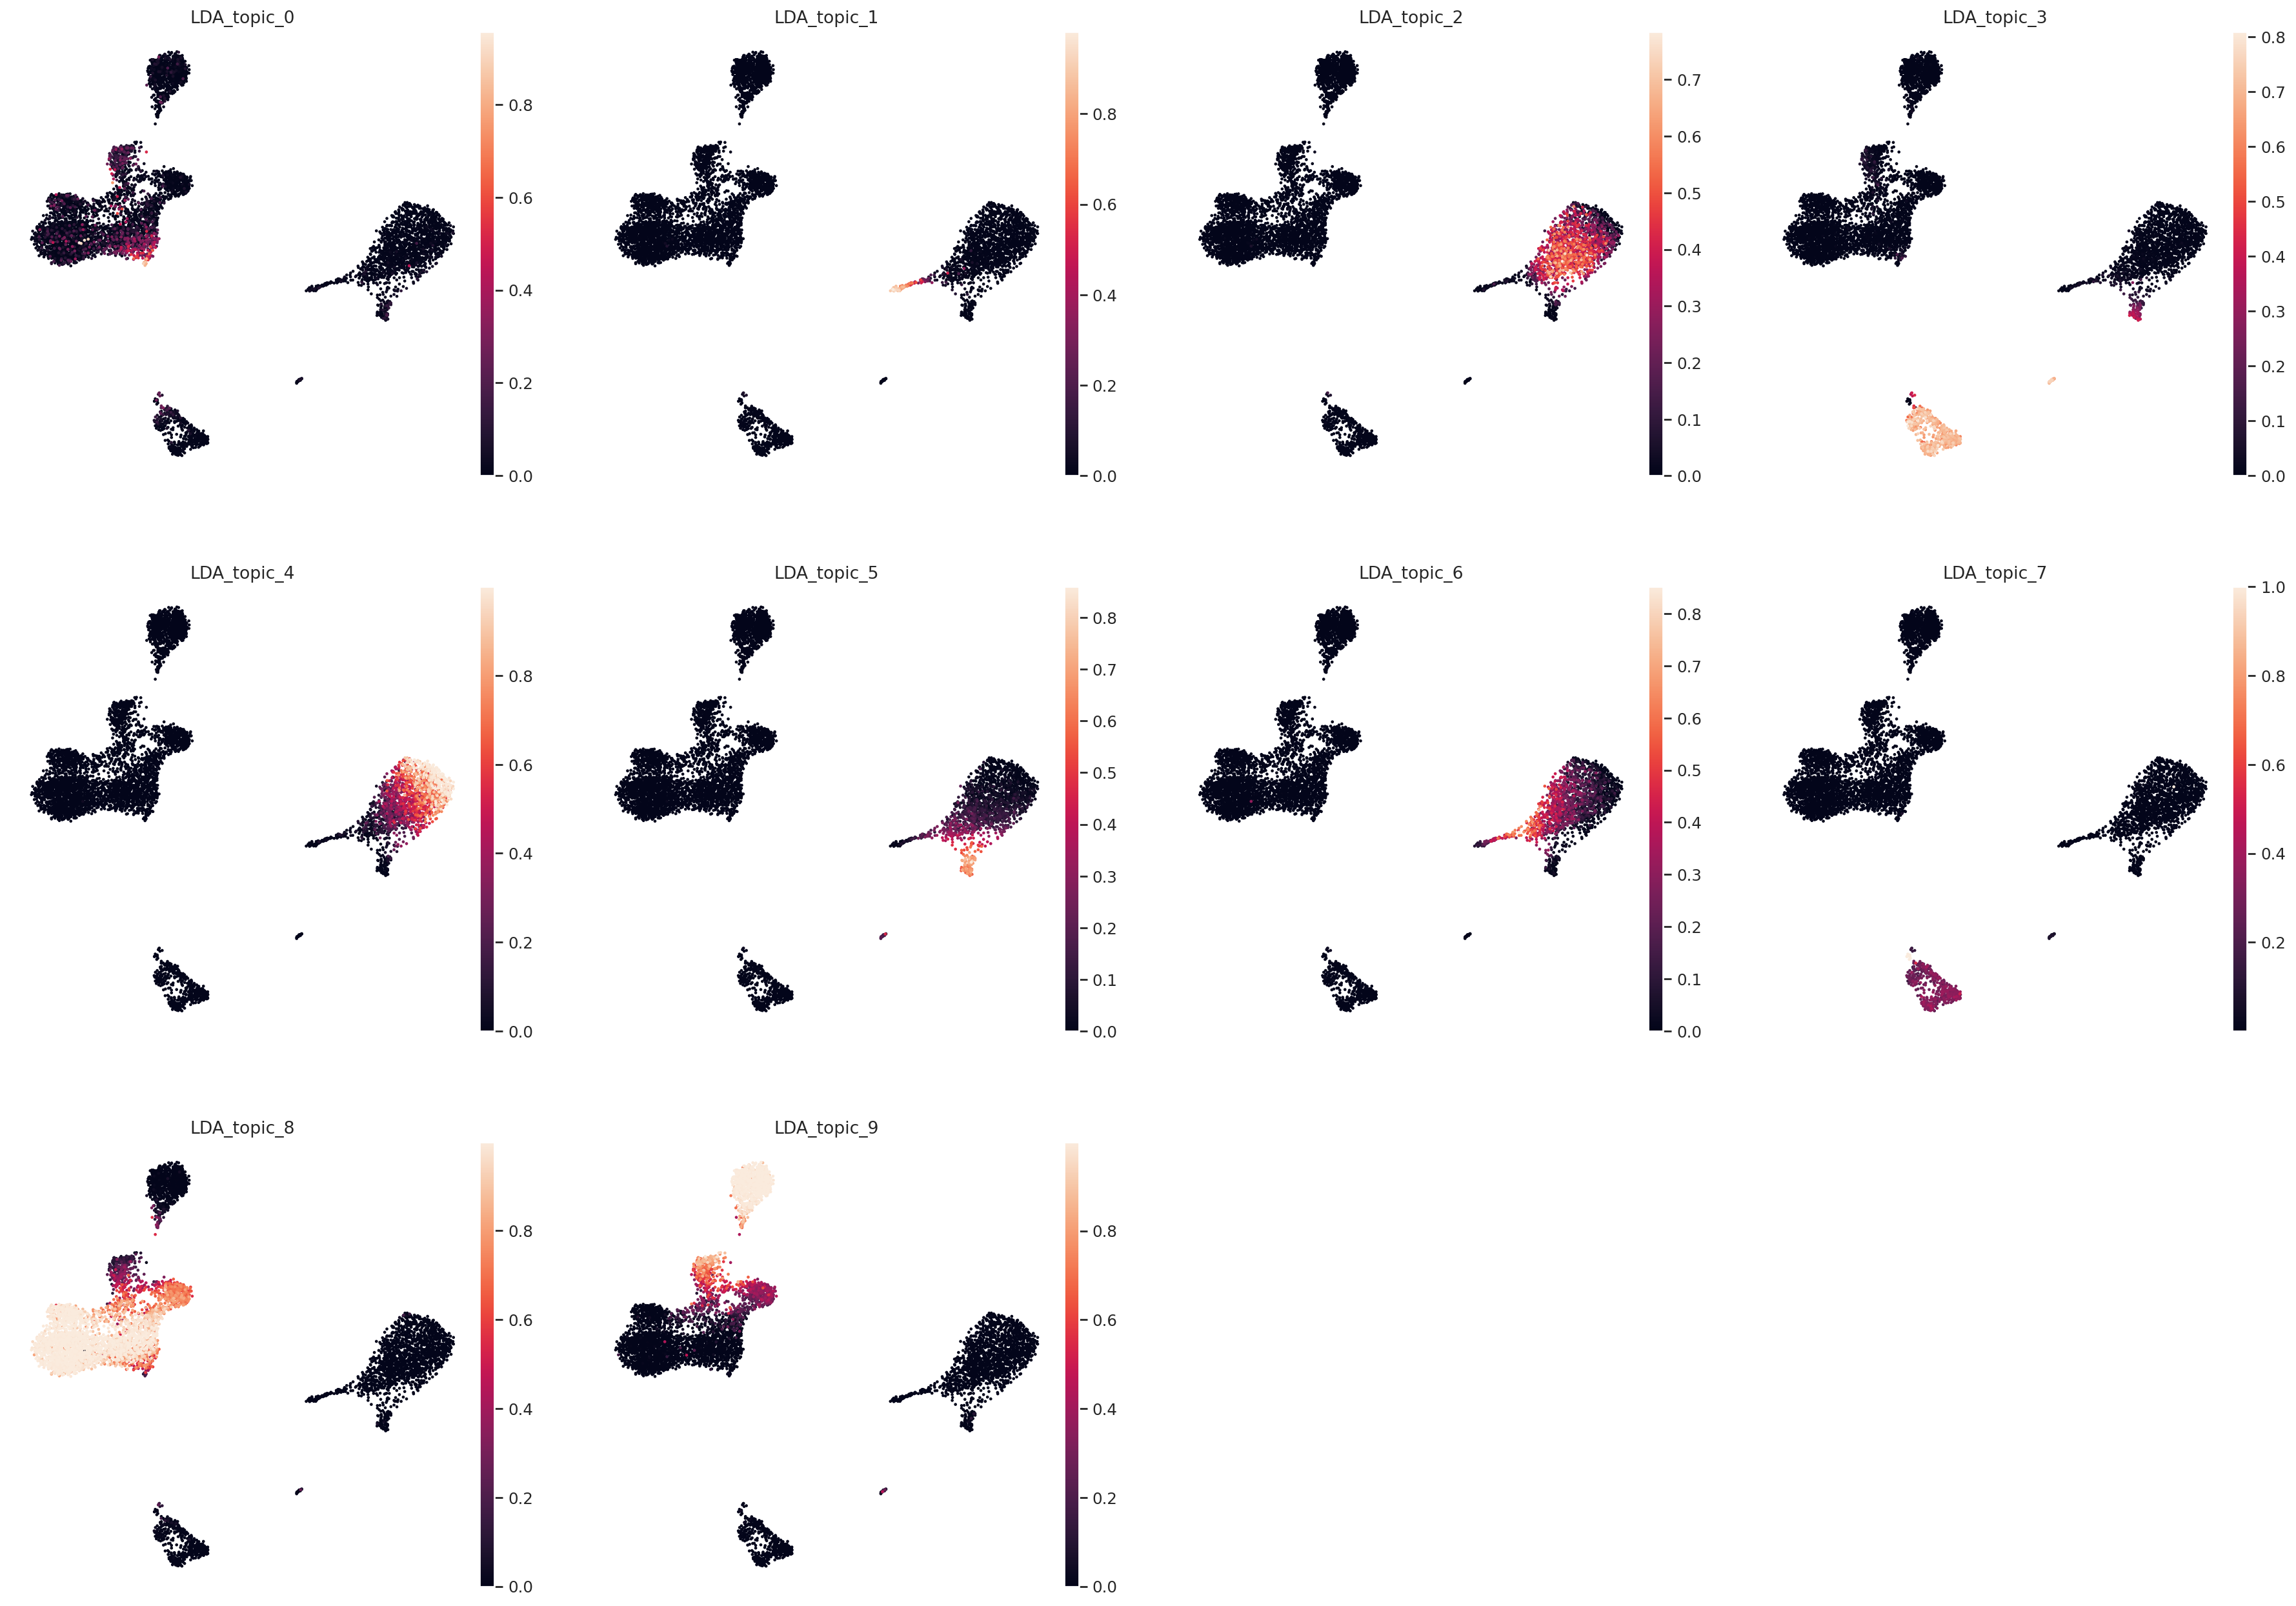

In [12]:
sc.pl.embedding(
    adata,
    "raw_counts_umap",
    color=[f"LDA_topic_{i}" for i in range(n_topics)],
    frameon=False,
)

### Plot UMAP in topic space

In [13]:
sc.pp.neighbors(adata, use_rep="X_LDA", n_neighbors=20, metric="hellinger")
sc.tl.umap(adata)

# Save UMAP to custom .obsm field.
adata.obsm["topic_space_umap"] = adata.obsm["X_umap"].copy()

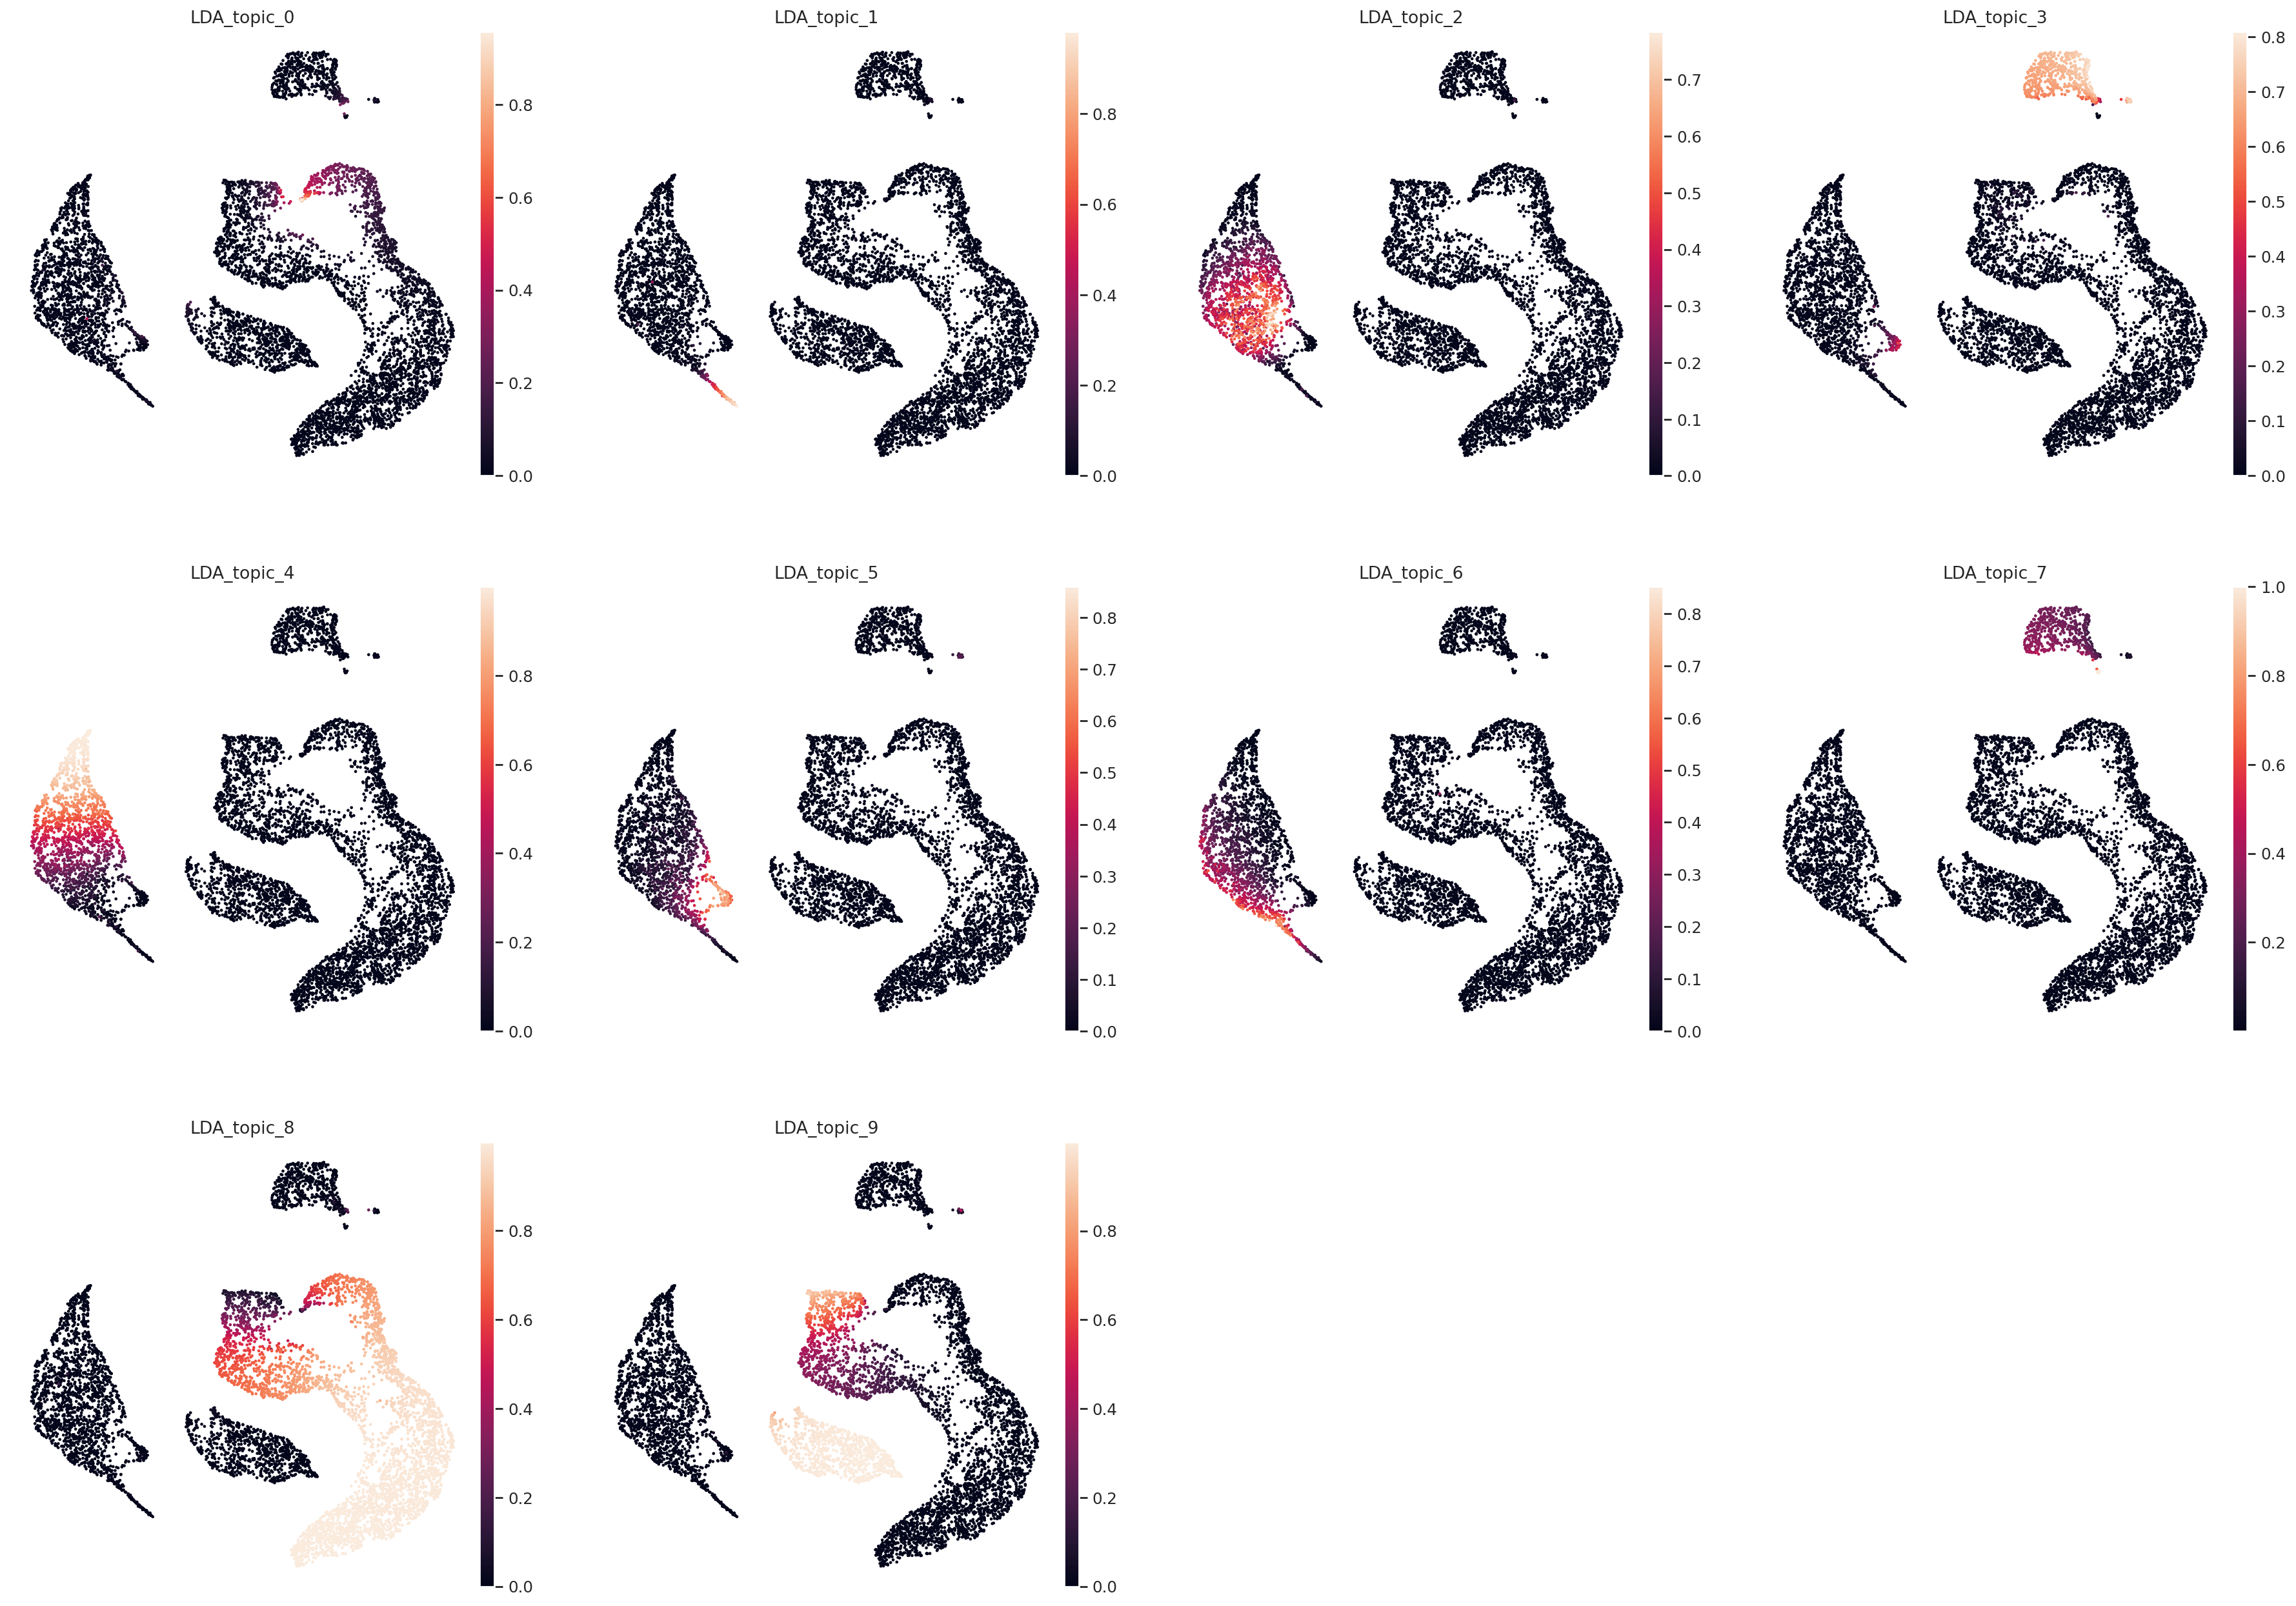

In [14]:
sc.pl.embedding(
    adata,
    "topic_space_umap",
    color=[f"LDA_topic_{i}" for i in range(n_topics)],
    frameon=False,
)

### Find top genes per topic

Similar to the topic proportions, `model.get_feature_by_topic()` returns a Monte Carlo estimate of the gene by topic matrix, which contains the proportion that a gene is weighted in each topic. This is also due to another approximation of the Dirichlet with a logistic-Normal distribution. We can inspect each topic in this matrix and sort by proportion allocated to each gene to determine top genes characterizing each topic.

In [15]:
feature_by_topic = model.get_feature_by_topic()
feature_by_topic.head()

topic_0   topic_1   topic_2   topic_3       topic_4   topic_5  \
index                                                                        
AL645608.8  0.000006  0.000055  0.000002  0.000003  2.650438e-06  0.000002   
HES4        0.000008  0.001070  0.000007  0.000013  7.052645e-06  0.000010   
ISG15       0.001506  0.000278  0.000014  0.000570  2.733733e-04  0.000084   
TNFRSF18    0.000066  0.000006  0.000002  0.000010  8.475461e-07  0.000002   
TNFRSF4     0.000045  0.000005  0.000002  0.000005  1.578560e-06  0.000004   

             topic_6   topic_7   topic_8   topic_9  
index                                               
AL645608.8  0.000003  0.000006  0.000001  0.000002  
HES4        0.000030  0.000009  0.000006  0.000006  
ISG15       0.001458  0.000200  0.001160  0.001372  
TNFRSF18    0.000002  0.000041  0.000387  0.000132  
TNFRSF4     0.000003  0.000009  0.000809  0.000057

In [16]:
rank_by_topic = pd.DataFrame()
for i in range(n_topics):
    topic_name = f"topic_{i}"
    topic = feature_by_topic[topic_name].sort_values(ascending=False)
    rank_by_topic[topic_name] = topic.index
    rank_by_topic[f"{topic_name}_prop"] = topic.values

In [17]:
rank_by_topic.head()

topic_0  topic_0_prop topic_1  topic_1_prop topic_2  topic_2_prop   topic_3  \
0    ACTB      0.250761     FTL      0.099662     LYZ      0.071014      CD74   
1  TMSB4X      0.132250    ACTB      0.074163    FTH1      0.049132   HLA-DRA   
2  TMSB10      0.088221  TMSB4X      0.059276     FTL      0.040657    TMSB4X   
3   ACTG1      0.084450    FTH1      0.051802   NEAT1      0.029303  HLA-DRB1   
4  S100A4      0.037430  S100A4      0.031290    ACTB      0.028314    TMSB10   

   topic_3_prop topic_4  topic_4_prop  topic_5  topic_5_prop topic_6  \
0      0.148474  S100A9      0.145165     ACTB      0.068644     FTL   
1      0.082345  S100A8      0.101481  HLA-DRA      0.066628    FTH1   
2      0.057995     LYZ      0.056132      LYZ      0.057734  TMSB4X   
3      0.047452     FTL      0.044074     CD74      0.049384    ACTB   
4      0.044340    ACTB      0.038659     CST3      0.042179  TMSB10   

   topic_6_prop topic_7  topic_7_prop topic_8  topic_8_prop topic_9  \
0      0.102359    IGKC      0.251105  TMSB4X      0.126876    ACTB   
1      0.080575   IGLC2      0.136026  TMSB10      0.085798  TMSB4X   
2      0.052844   IGHA1      0.088759    ACTB      0.082420    GNLY   
3      0.040321    IGHM      0.059784    JUNB      0.033901    NKG7   
4      0.027831   IGLC3      0.041155    FTH1      0.027448    CCL5   

   topic_9_prop  
0      0.087591  
1      0.087425  
2      0.070292  
3      0.053497  
4      0.040805